## Stacking

In [15]:
## Import Libraries
import itertools
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from mlxtend.classifier import StackingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

import warnings
warnings.filterwarnings('ignore')

In [16]:
## reading and inspect the data
columns = [
    'Sample_Number',
    'Clump_Thickness',
    'Uniformity_of_Cell_Size',
    'Uniformity_of_Cell_Shape',
    'Marginal_Adhesion',
    'Single_Epithelial_Cell_Size',
    'Bare_Nuclei',
    'Bland_Chromatin',
    'Normal_Nucleoli',
    'Mitoses',
    'Class'
]
df = pd.read_csv(
    filepath_or_buffer = '.../breast-cancer-wisconsin-data-old.csv',
    header = 0,
    names = columns,
    usecols = columns[1:], # do not use the first column
    na_values = '?' # convert the '?' to NA
)

In [17]:
print(df['Bare_Nuclei'].value_counts(dropna = False))

Bare_Nuclei
1.0     402
10.0    132
2.0      30
5.0      30
3.0      28
8.0      21
4.0      19
NaN      16
9.0       9
7.0       8
6.0       4
Name: count, dtype: int64


In [18]:
# Convert the DataFrame object into NumPy array otherwise you will not be able to impute
values = df.values

# define the criteria for dealing with the missing values
imputer = SimpleImputer(
    missing_values = np.nan,
    strategy = 'median'
)

# Now impute it
imputedData = imputer.fit_transform(values)

In [19]:
scaler = MinMaxScaler(feature_range = (0, 1))
normalizedData = scaler.fit_transform(imputedData)

In [20]:
# move the data back to a dataframe
df_n = pd.DataFrame.from_records(normalizedData, columns = columns[1:])
df_n['Class'] = df_n['Class'].astype(np.int8)
df_n.sample(5)

,Clump_Thickness,Uniformity_of_Cell_Size,Uniformity_of_Cell_Shape,Marginal_Adhesion,Single_Epithelial_Cell_Size,Bare_Nuclei,Bland_Chromatin,Normal_Nucleoli,Mitoses,Class
476,0.333333,0.000000,0.111111,0.000000,0.111111,0.000000,0.000000,0.000000,0.000000,0
531,0.333333,0.111111,0.111111,0.000000,0.111111,0.000000,0.111111,0.000000,0.000000,0
40,0.555556,0.555556,0.555556,0.888889,0.555556,0.000000,0.666667,0.777778,0.000000,0
432,0.444444,0.000000,0.000000,0.000000,0.111111,0.000000,0.111111,0.111111,0.000000,0
14,0.777778,0.666667,0.444444,1.000000,0.666667,0.888889,0.444444,0.444444,0.333333,1


In [21]:
# create X and y to match Scikit-Learn parlance

features = columns[1:-1] # discard the first and last columns
outcome = 'Class'

# X include all the features
X = df_n[features].copy()
# y is the target variable
y = df_n[outcome].copy()

In [22]:
X.head()

,Clump_Thickness,Uniformity_of_Cell_Size,Uniformity_of_Cell_Shape,Marginal_Adhesion,Single_Epithelial_Cell_Size,Bare_Nuclei,Bland_Chromatin,Normal_Nucleoli,Mitoses
0,0.444444,0.000000,0.000000,0.000000,0.111111,0.000000,0.222222,0.000000,0.0
1,0.444444,0.333333,0.333333,0.444444,0.666667,1.000000,0.222222,0.111111,0.0
2,0.222222,0.000000,0.000000,0.000000,0.111111,0.111111,0.222222,0.000000,0.0
3,0.555556,0.777778,0.777778,0.000000,0.222222,0.333333,0.222222,0.666667,0.0
4,0.333333,0.000000,0.000000,0.222222,0.111111,0.000000,0.222222,0.000000,0.0


In [23]:
## Create training and testing subsets
test_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = test_size,
                                                    random_state = 100666001,
                                                    stratify = y)

In [24]:
np.random.seed(0)
# create the sub models
clf1 = KNeighborsClassifier(n_neighbors = 1)
clf1.fit(X_train, y_train)
clf2 = RandomForestClassifier(n_estimators = 10, random_state = 1)
clf2.fit(X_train, y_train)
clf3 = GaussianNB()
clf3.fit(X_train, y_train)
lr = LogisticRegression(multi_class = 'auto', solver = 'lbfgs')
lr.fit(X_train, y_train)

LogisticRegression()

In [25]:
# create the ensemble model
sclf = StackingClassifier(
    classifiers = [clf1, clf2, clf3],
    meta_classifier = lr)
sclf.fit(X_train, y_train)
print()

In [26]:
kfold = model_selection.KFold(n_splits = 10)
results = model_selection.cross_val_score(sclf, X_train, y_train, cv = kfold)
print('Stacking, Cross-Validation mean: %.4f' % results.mean())

Stacking, Cross-Validation mean: 0.9714


In [27]:
def show_summary_report(actual, prediction):
    if isinstance(actual, pd.Series):
        actual = actual.values
    if actual.dtype.name == 'object':
        actual = actual.astype(int)
    if prediction.dtype.name == 'object':
        prediction = prediction.astype(float)
    prediction_int = np.round(prediction)
    accuracy_ = accuracy_score(actual, prediction_int)
    precision_ = precision_score(actual, prediction_int)
    recall_ = recall_score(actual, prediction_int)
    roc_auc_ = roc_auc_score(actual, prediction)
    print('Accuracy : %.4f [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0' % accuracy_)
    print('Precision: %.4f [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0' % precision_)
    print('Recall   : %.4f [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0' % recall_)
    print('ROC AUC  : %.4f                                                                     Best: 1, Worst: < 0.5' % roc_auc_)
    print('-' * 107)
    print('TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples')
    # Confusion Matrix
    mat = confusion_matrix(actual, prediction_int)
    # Precision/Recall
    precision, recall, _ = precision_recall_curve(actual, prediction)
    average_precision = average_precision_score(actual, prediction_int)
    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(actual, prediction)
    roc_auc = auc(fpr, tpr)
    # plot
    fig, ax = plt.subplots(1, 3, figsize = (18, 6))
    fig.subplots_adjust(left = 0.02, right = 0.98, wspace = 0.2)
    # Confusion Matrix
    sns.heatmap(mat.T, square = True, annot = True, fmt = 'd', cbar = False, cmap = 'Blues', ax = ax[0])
    ax[0].set_title('Confusion Matrix')
    ax[0].set_xlabel('True label')
    ax[0].set_ylabel('Predicted label')
    # Precision/Recall
    step_kwargs = {'step': 'post'}
    ax[1].step(recall, precision, color = 'b', alpha = 0.2, where = 'post')
    ax[1].fill_between(recall, precision, alpha = 0.2, color = 'b', **step_kwargs)
    ax[1].set_ylim([0.0, 1.0])
    ax[1].set_xlim([0.0, 1.0])
    ax[1].set_xlabel('Recall')
    ax[1].set_ylabel('Precision')
    ax[1].set_title('2-class Precision-Recall curve')
    # ROC
    ax[2].plot(fpr, tpr, color = 'darkorange', lw = 2, label = 'ROC curve (AUC = %0.2f)' % roc_auc)
    ax[2].plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle = '--')
    ax[2].set_xlim([0.0, 1.0])
    ax[2].set_ylim([0.0, 1.0])
    ax[2].set_xlabel('False Positive Rate')
    ax[2].set_ylabel('True Positive Rate')
    ax[2].set_title('Receiver Operating Characteristic')
    ax[2].legend(loc = 'lower right')
    plt.show()
    return (accuracy_, precision_, recall_, roc_auc_)

********
* K-NN *
********
Accuracy : 1.0000 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 1.0000 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 1.0000 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 1.0000                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


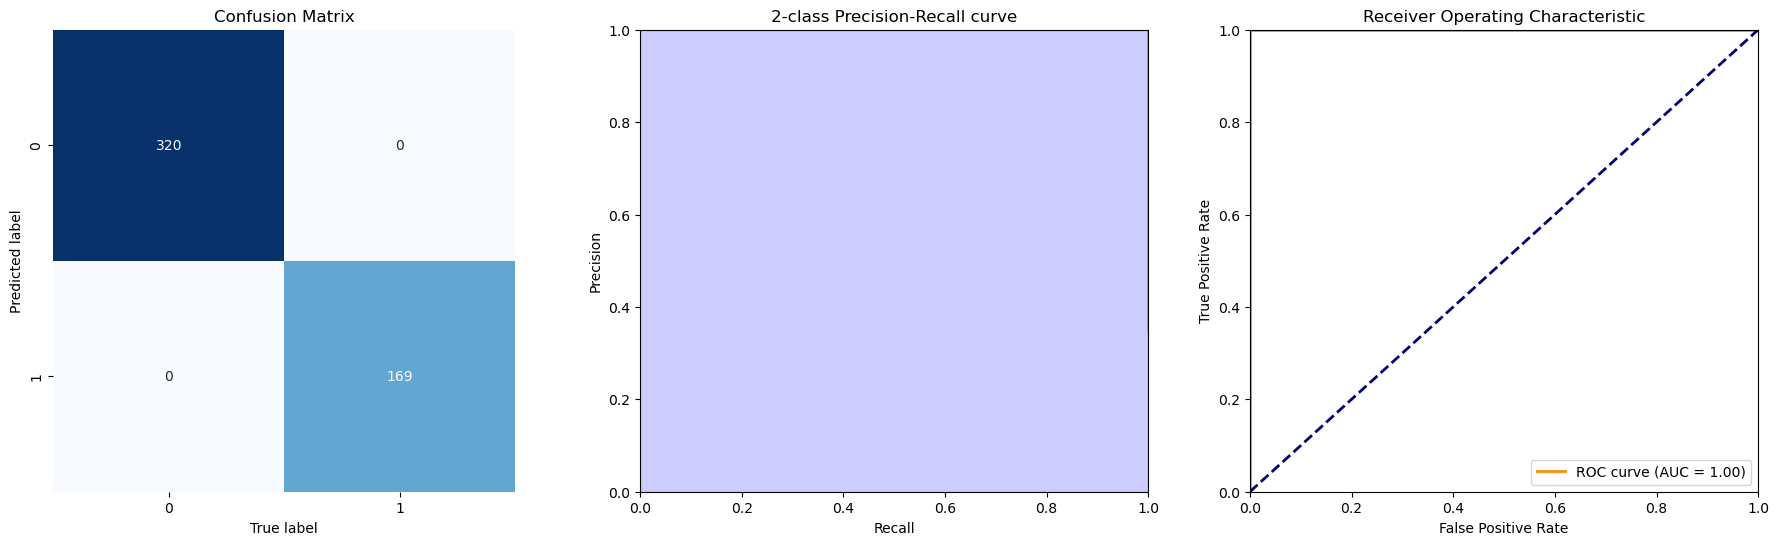


*****************
* Random Forest *
*****************
Accuracy : 0.9959 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 1.0000 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.9882 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 1.0000                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


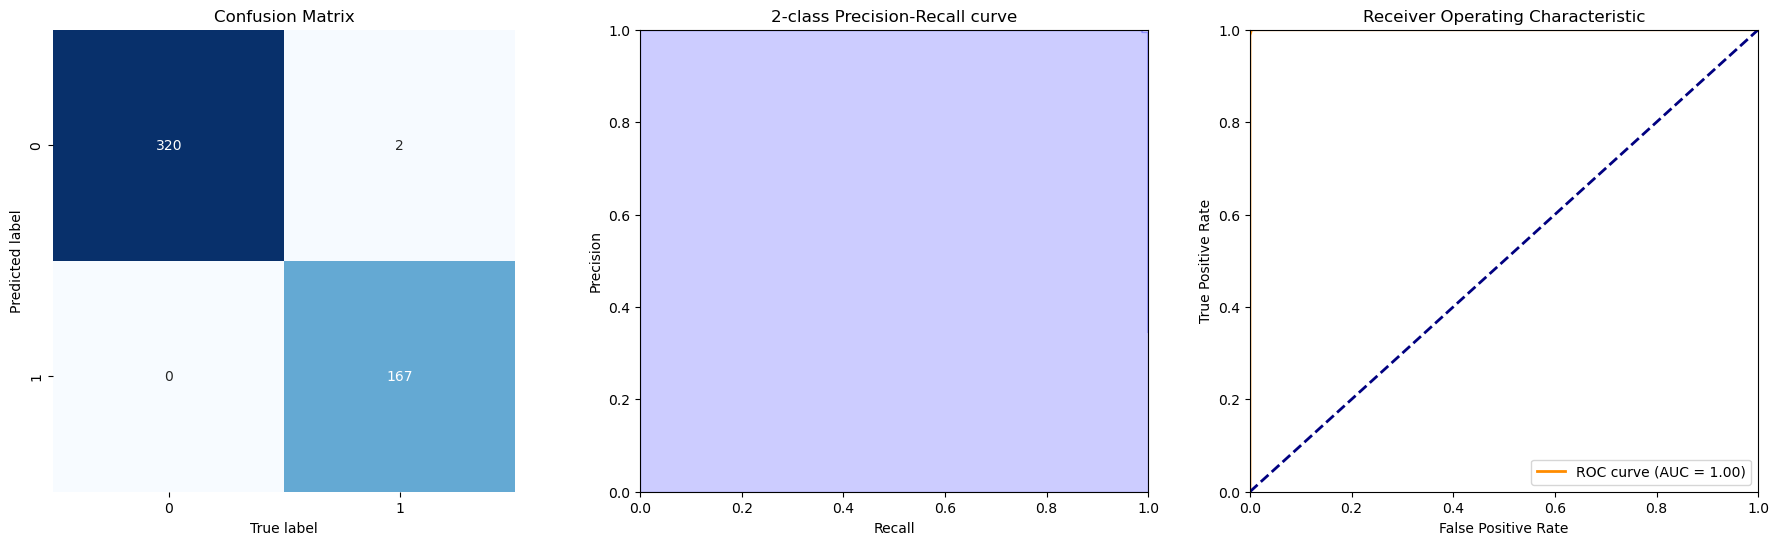


***************
* Naïve Bayes *
***************
Accuracy : 0.9571 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.9066 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.9763 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.9868                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


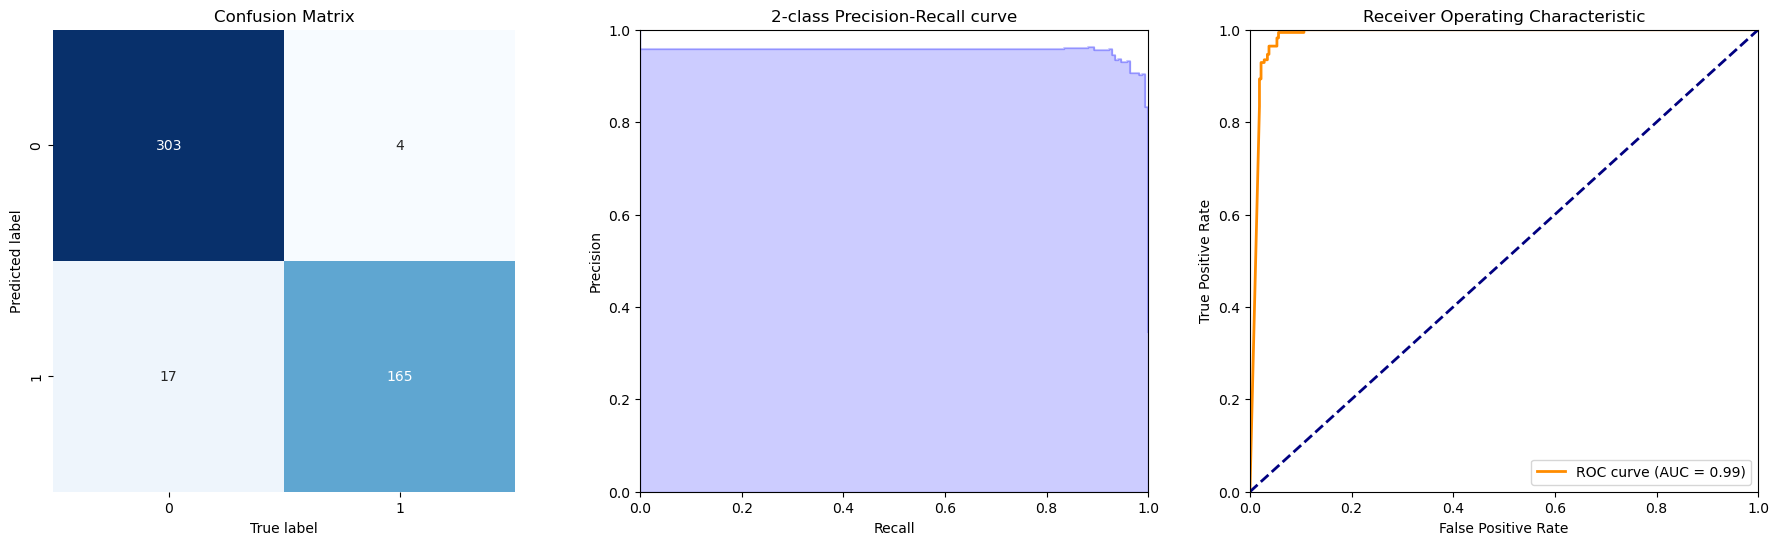


***********************
* Logistic Regression *
***********************
Accuracy : 0.9673 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.9581 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.9467 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.9959                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


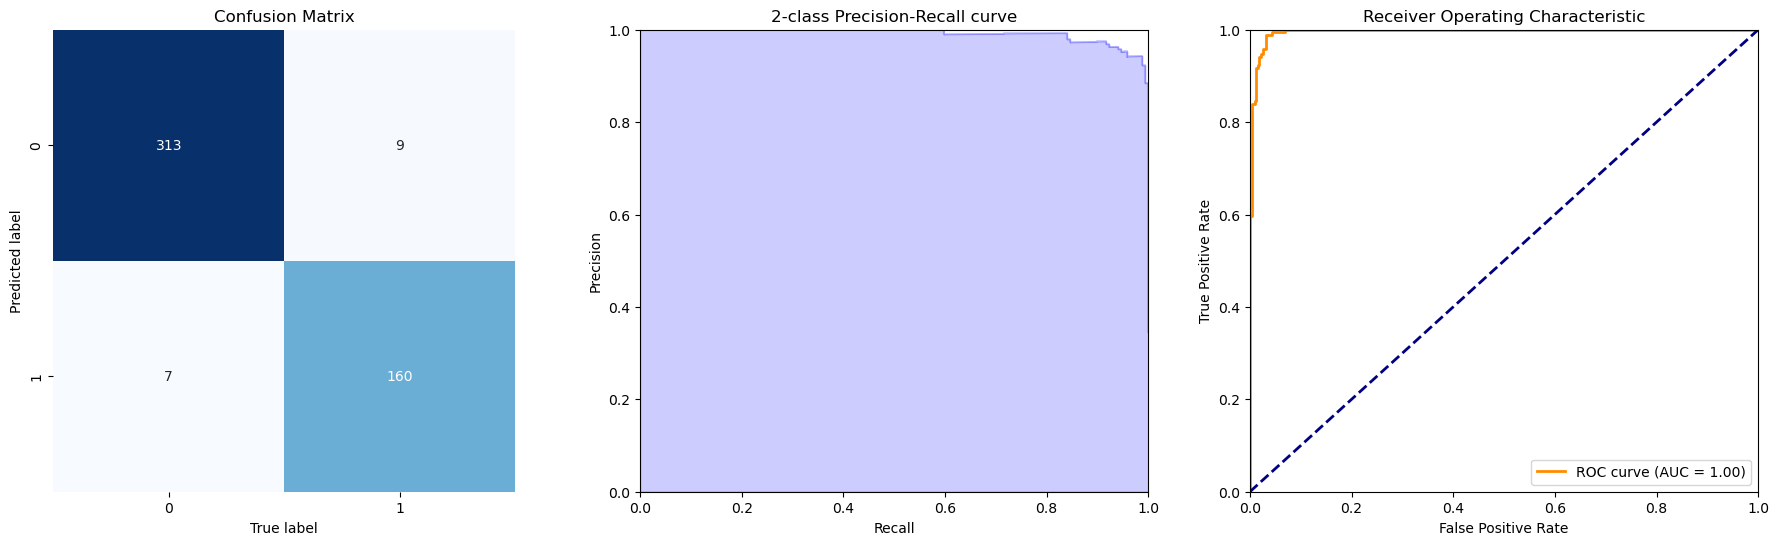


************
* Stacking *
************
Accuracy : 0.9959 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 1.0000 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.9882 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 1.0000                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


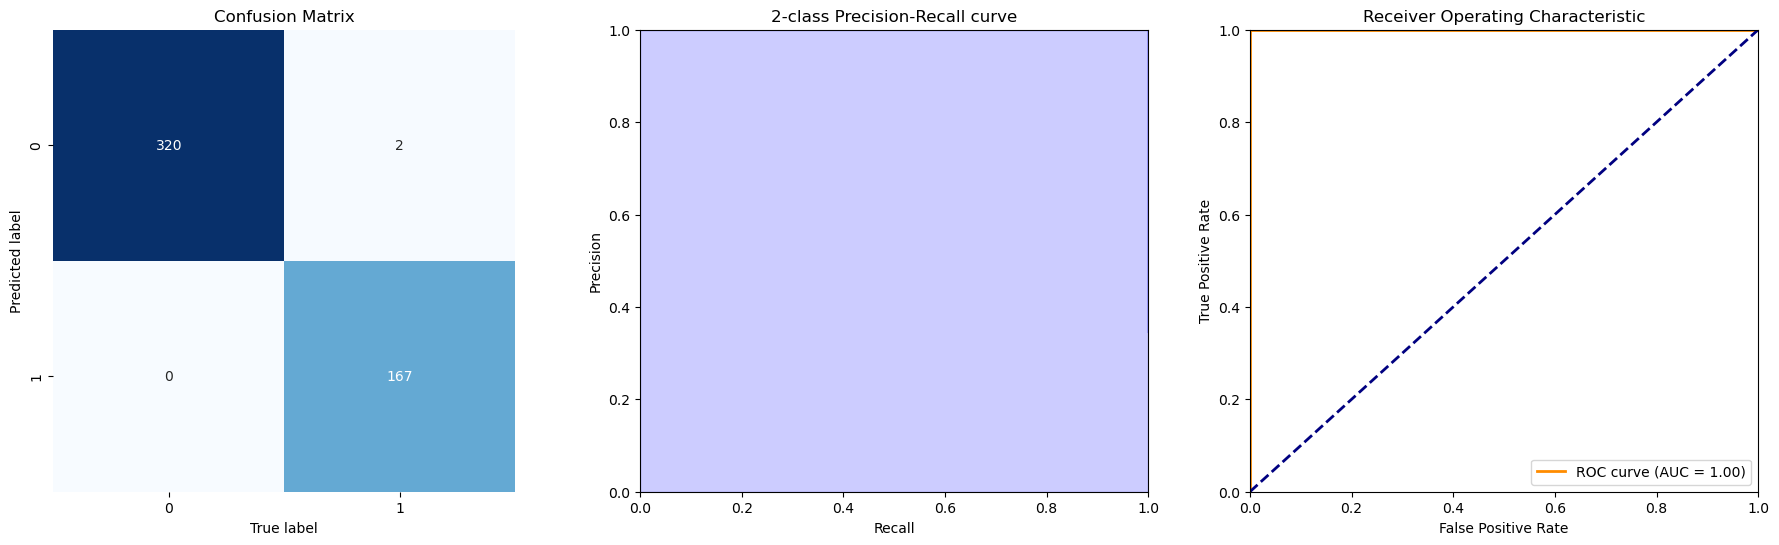

In [28]:
# Keep the results in a dataframe
results = pd.DataFrame(columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'ROC_AUC'])
models = ['K-NN', 'Random Forest', 'Naïve Bayes', 'Logistic Regression', 'Stacking']
for i, m in enumerate([clf1, clf2, clf3, lr, sclf]):
    print('*' * (len(models[i]) + 4))
    print('* %s *' % models[i])
    print('*' * (len(models[i]) + 4))
    predictions = m.predict_proba(X_train)[:,1]
    # show the report
    accuracy_, precision_, recall_, roc_auc_ = show_summary_report(y_train, predictions)
    # keep the results
    results.loc[i] = {'Model': models[i],
                      'Accuracy': accuracy_,
                      'Precision': precision_,
                      'Recall': recall_,
                      'ROC_AUC': roc_auc_}
    print()